In [2]:
%matplotlib inline
from pprint import pprint
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister,transpile
from qiskit.visualization import array_to_latex, plot_distribution, plot_histogram
from qiskit.circuit.library import GroverOperator
from qiskit_aer import AerSimulator
from qiskit_algorithms import AmplificationProblem
from qiskit_algorithms import Grover
from qiskit.primitives import Sampler
from qiskit.providers.fake_provider import FakeWashington
import numpy as np
import pandas as pd
import os
from tqdm.notebook import trange
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler as IBMSampler
from utils import get_image_path

[![Hanoi Tower](https://upload.wikimedia.org/wikipedia/commons/thumb/0/07/Tower_of_Hanoi.jpeg/450px-Tower_of_Hanoi.jpeg)](https://en.wikipedia.org/wiki/Tower_of_Hanoi)

[![Hanoi Tower steps](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Iterative_algorithm_solving_a_6_disks_Tower_of_Hanoi.gif/330px-Iterative_algorithm_solving_a_6_disks_Tower_of_Hanoi.gif)](https://en.wikipedia.org/wiki/Tower_of_Hanoi)

| one   | two   | three |
|-------|-------|-------|
|$1\to3$|$1\to2$|$1\to2$| 
|       |$1\to3$|$1\to3$|
|       |$2\to3$|$2\to3$|
|       |       |$1\to3$|
|       |       |$3\to2$|
|       |       |$3\to1$|
|       |       |$2\to1$|
|       |       |$2\to3$|
|       |       |$1\to2$|
|       |       |$1\to3$|
|       |       |$2\to3$|

In [11]:
def hanoi(disc, start, aux, end, steps):
    if(disc == 0):
        return

    hanoi(disc-1, start, end, aux, steps)
    steps.append((disc,  start, end))
    hanoi(disc-1, aux, start, end, steps)
    return steps

In [3]:
steps = hanoi(2, 0, 1, 2, [])
pprint(steps, width=20)

[(1, 0, 1),
 (2, 0, 2),
 (1, 1, 2)]


In [4]:
steps_for_3 = hanoi(3, 0, 1, 2, [])
pprint(steps_for_3, width=20)

[(1, 0, 2),
 (2, 0, 1),
 (1, 2, 1),
 (3, 0, 2),
 (1, 1, 0),
 (2, 1, 2),
 (1, 0, 2)]


In [5]:
def hanoi_solver(towers, steps):
    for _, from_, to_ in steps:
        
        value = towers[from_].pop()
        towers[to_].append(value)
        print(towers)

towers = [list(range(3, 0, -1)), [], []]
hanoi_solver(towers, steps_for_3)
print('result: ', towers)

[[3, 2], [], [1]]
[[3], [2], [1]]
[[3], [2, 1], []]
[[], [2, 1], [3]]
[[1], [2], [3]]
[[1], [], [3, 2]]
[[], [], [3, 2, 1]]
result:  [[], [], [3, 2, 1]]


---

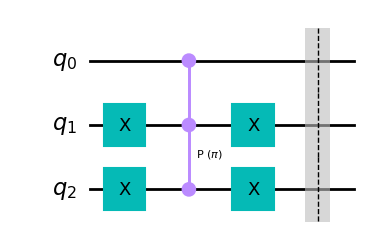

In [10]:
def generate_hanoi_u(total_discs=3, n_qubits=3, total_towers=3):
    assert total_discs <= 2**n_qubits, "Invalid size"
    assert total_towers > 0 and total_towers <= 3, "invalid towers amount"


    total_qubits = n_qubits*total_towers
    tower = QuantumCircuit(total_qubits, name="hanoi U")


    for i in range(1, total_discs+1):
        binary = f"{i:0{total_qubits}b}"[::-1]
        zeros = [ i for i,v in enumerate(binary) if v=='0']
        has_zeros = len(zeros) > 0
        if(has_zeros): tower.x(zeros)
        tower.mcp(np.pi, list(range(1, total_qubits)), 0)
        if(has_zeros): tower.x(zeros)
        tower.barrier()

    return tower

tower = generate_hanoi_u(n_qubits=1, total_discs=1)
tower.draw('mpl', style="clifford")

In [7]:
def get_unitary(qc, sim=AerSimulator()):
    qc_copy = qc.copy()
    qc_copy.save_unitary()
    result = sim.run(transpile(qc_copy, sim), shots=1000).result().get_unitary()
    display(array_to_latex(result, max_size=10000))

get_unitary(tower)

<IPython.core.display.Latex object>

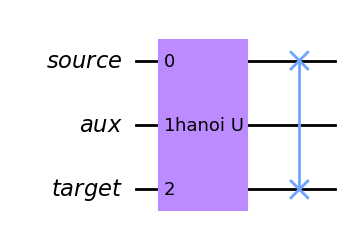

<IPython.core.display.Latex object>

In [31]:
source = QuantumRegister(1, name="source")
auxiliary = QuantumRegister(1, name="aux")
target = QuantumRegister(1, name="target")

hanoi_1 = QuantumCircuit(source, auxiliary, target)
hanoi_1.append(generate_hanoi_u(n_qubits=1, total_discs=1), [*source, *auxiliary, *target])
hanoi_1.swap(source, target)

display(hanoi_1.draw('mpl', style="clifford", filename=get_image_path("hanoi_1_disc.png")))
get_unitary(hanoi_1)

In [19]:
def test_result(oracle, expected, filename=None, sampler=Sampler()):
    problem = AmplificationProblem(oracle, is_good_state=expected)
    grover = Grover(sampler=sampler)
    result = grover.amplify(problem)
    print(f"Reached the expected values: {result.oracle_evaluation}")
    print(f"Top measurments: {result.top_measurement}")
    plot = plot_distribution(result.circuit_results)
    if(filename):
        plt.savefig(filename)
    display(plot)

Reached the expected values: True
Top measurments: 100


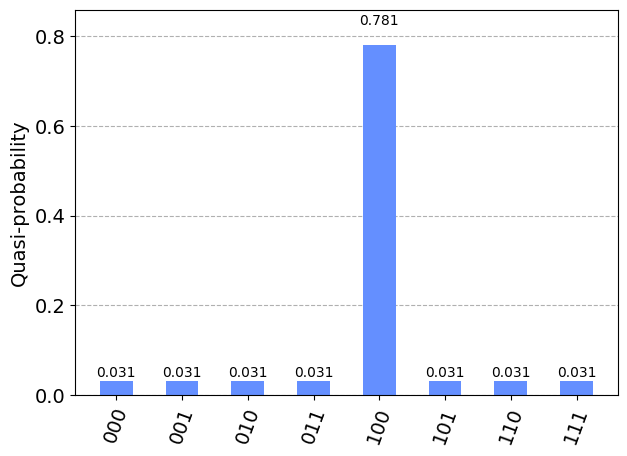

<Figure size 640x480 with 0 Axes>

In [46]:
test_result(hanoi_1, ['100'], filename=get_image_path("result_hanoi_1_disc.png"))

In [11]:
hanoi(2, 0, 1, 2, [])

[(1, 0, 1), (2, 0, 2), (1, 1, 2)]

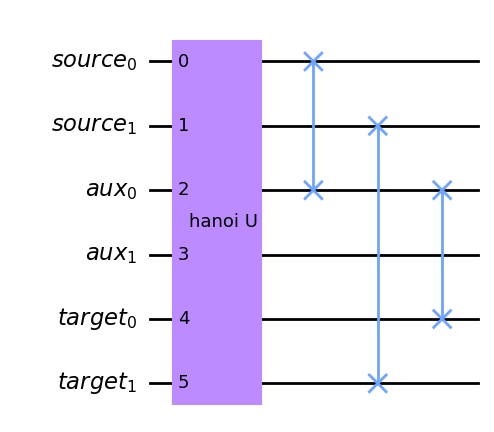

<IPython.core.display.Latex object>

In [50]:
source = QuantumRegister(2, name="source")
auxiliary = QuantumRegister(2, name="aux")
target = QuantumRegister(2, name="target")

hanoi_2 = QuantumCircuit(source, auxiliary, target)
hanoi_2.append(generate_hanoi_u(n_qubits=2, total_discs=2), [*source, *auxiliary, *target])


hanoi_2.swap(source[0], auxiliary[0])
hanoi_2.swap(source[1], target[1])
hanoi_2.swap(auxiliary[0], target[0])

display(hanoi_2.draw('mpl', style="clifford", filename=get_image_path("hanoi_2_discs.png")))
get_unitary(hanoi_2)

Reached the expected values: True
Top measurments: 010000


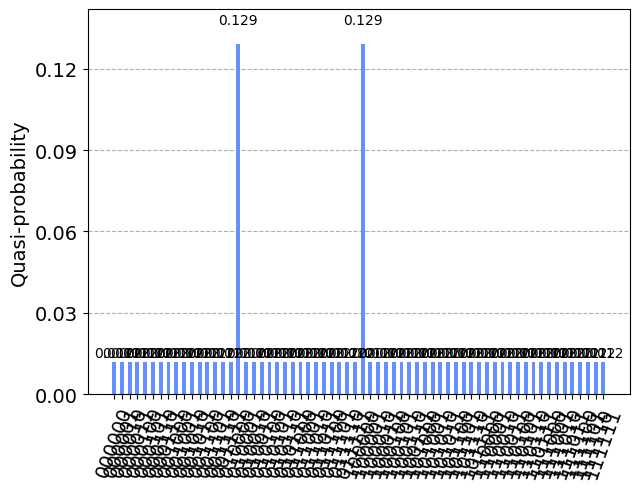

<Figure size 640x480 with 0 Axes>

In [48]:
test_result(hanoi_2, ['010000', '100000'], filename=get_image_path("result_hanoi_2_discs.png"))

In [14]:
hanoi(3, 0, 1, 2, [])

[(1, 0, 2), (2, 0, 1), (1, 2, 1), (3, 0, 2), (1, 1, 0), (2, 1, 2), (1, 0, 2)]

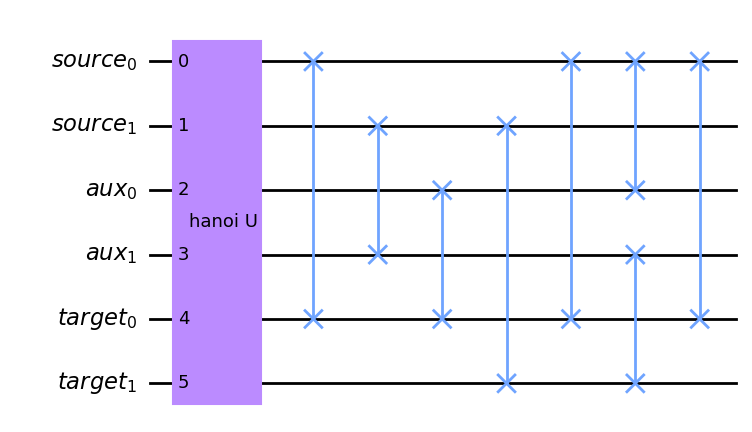

<IPython.core.display.Latex object>

In [51]:
source = QuantumRegister(2, name="source")
auxiliary = QuantumRegister(2, name="aux")
target = QuantumRegister(2, name="target")

hanoi_3 = QuantumCircuit(source, auxiliary, target)
hanoi_3.append(generate_hanoi_u(n_qubits=2), [*source, *auxiliary, *target])

#(1, 0, 2)
hanoi_3.swap(source[0], target[0])
#(2, 0, 1)
hanoi_3.swap(source[1], auxiliary[1])
#(1, 2, 1)
hanoi_3.swap(target[0], auxiliary[0])
#(3, 0, 2)
hanoi_3.swap(source[0], target[0])
hanoi_3.swap(source[1], target[1])
#(1, 1, 0)
hanoi_3.swap(auxiliary[0], source[0])
#(2, 1, 2)
hanoi_3.swap(auxiliary[1], target[1])
#(1, 0, 2)
hanoi_3.swap(source[0], target[0])

display(hanoi_3.draw('mpl',style="clifford", filename=get_image_path("hanoi_3_discs.png")))
get_unitary(hanoi_3)

Reached the expected values: True
Top measurments: 100000


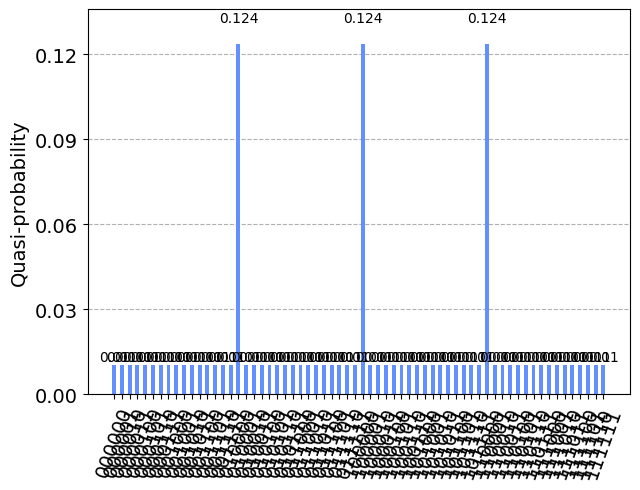

<Figure size 640x480 with 0 Axes>

In [52]:
test_result(hanoi_3, ['010000', '100000', '110000'], filename=get_image_path("result_hanoi_3_discs.png"))

In [9]:
def auto_hanoi(n, enable_display=True, filename=None):
    n_qubits = len(str(bin(n))[2:])

    source = QuantumRegister(n_qubits, name="source")
    auxiliary = QuantumRegister(n_qubits, name="aux")
    target = QuantumRegister(n_qubits, name="target")
    
    qc = QuantumCircuit(source, auxiliary, target)
    qc.append(generate_hanoi_u(n_qubits=n_qubits, total_discs=n), [*source, *auxiliary, *target])

    steps = hanoi(n, 0, 1, 2, [])

    encoded_towers = {
        0: source,
        1: auxiliary,
        2: target
    }

    for value, from_, to in steps:
        binary = f"{value:0{n_qubits}b}"
        ones_pos = [ i for i, value in enumerate(binary) if value == '1' ]

        tower_from = encoded_towers[from_]
        tower_to = encoded_towers[to]
        
        for one_pos in ones_pos:
            qc.swap(tower_from[one_pos], tower_to[one_pos])
    
    if(enable_display): display(qc.draw('mpl', style="clifford", filename=filename))
    return qc


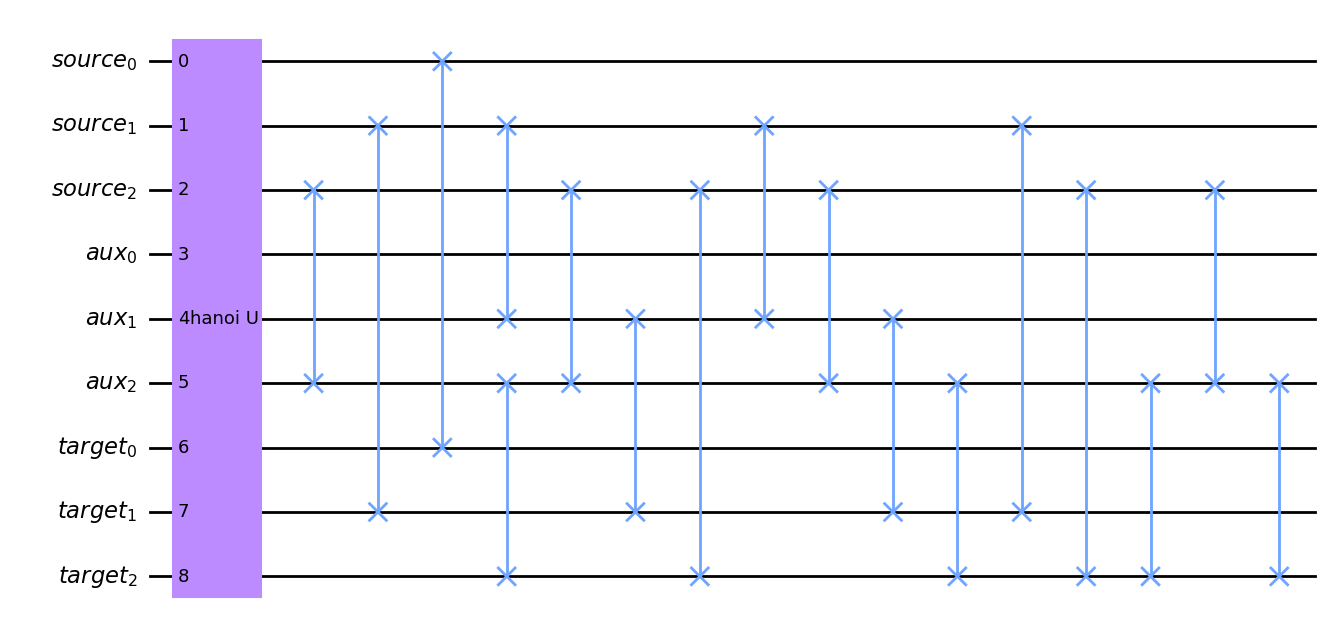

Reached the expected values: True
Top measurments: 001000000


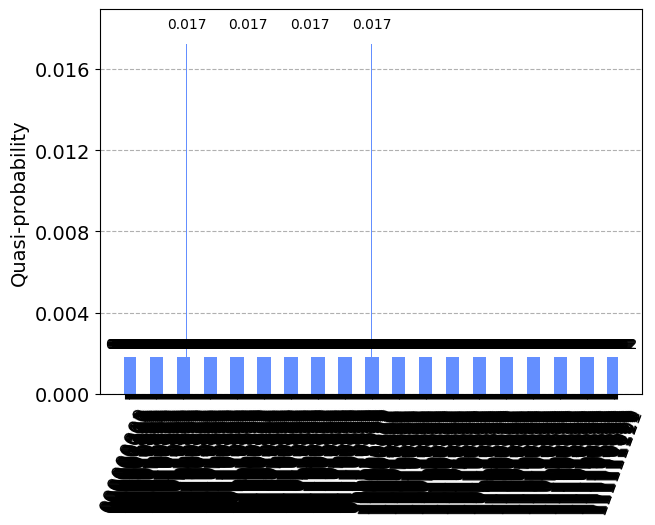

<Figure size 640x480 with 0 Axes>

In [54]:
hanoi_4 = auto_hanoi(4, filename=get_image_path("hanoi_4_discs.png"))
test_result(hanoi_4, ['001000000', '010000000', '011000000', '100000000'],filename=get_image_path("result_hanoi_4_discs.png"))

In [3]:
load_dotenv()
QiskitRuntimeService.save_account(channel="ibm_quantum", token=os.getenv("IBM_TOKEN"), overwrite=True)

In [4]:
service = QiskitRuntimeService()
options = Options(optimization_level=3)
options.execution.shots = 1000

In [13]:
ibm_backend = service.least_busy(operational=True, simulator=False)
display(ibm_backend.status())
print(f'num_qubits: {ibm_backend.num_qubits}') 

num_qubits: 127


In [82]:
def get_depth(start=1, end=10, backend=AerSimulator()):
    depths = pd.Series(dtype=np.int32)
    
    for n in trange(start, end):
        circuit = auto_hanoi(n, enable_display=False)
        depths[n] = transpile(circuit, backend=backend).depth()

    return depths

start = 1
end = 10
depths = get_depth(start=start, end=end)
washington_depths = get_depth(start=start, end=end, backend=FakeWashington())
ibmq_depths = get_depth(start=start, end=end, backend=ibm_backend)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [83]:
hanoi_steps = lambda n: len(hanoi(n, 1, 2, 3, []))
vec_hanoi = np.vectorize(hanoi_steps)
range_ = np.arange(start, end)
total_steps = pd.Series(vec_hanoi(range_), index=range_, dtype=np.int32)

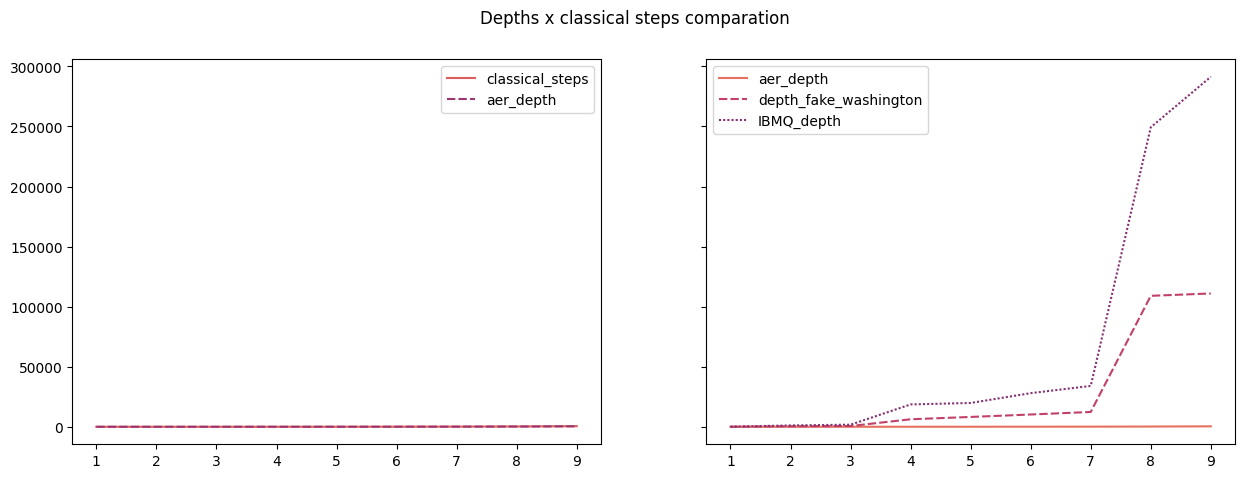

In [87]:
df = pd.DataFrame({"aer_depth":depths, "depth_fake_washington":washington_depths, "IBMQ_depth":ibmq_depths, "classical_steps":total_steps}, columns=["aer_depth", "depth_fake_washington", "IBMQ_depth", "classical_steps"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Depths x classical steps comparation')

sns.lineplot(ax=ax1, data=df[["classical_steps", "aer_depth"]], palette="flare")
sns.lineplot(ax=ax2, data=df[["aer_depth", "depth_fake_washington", "IBMQ_depth"]], palette="flare")
plt.savefig(get_image_path("hanoi_depths_comparation.png"))
plt.show()

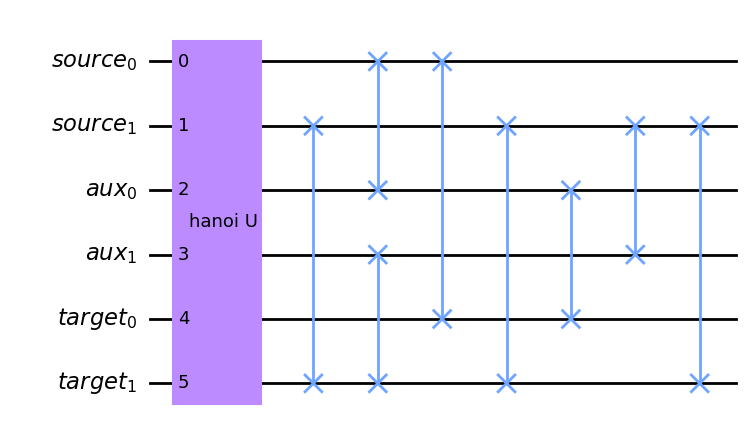

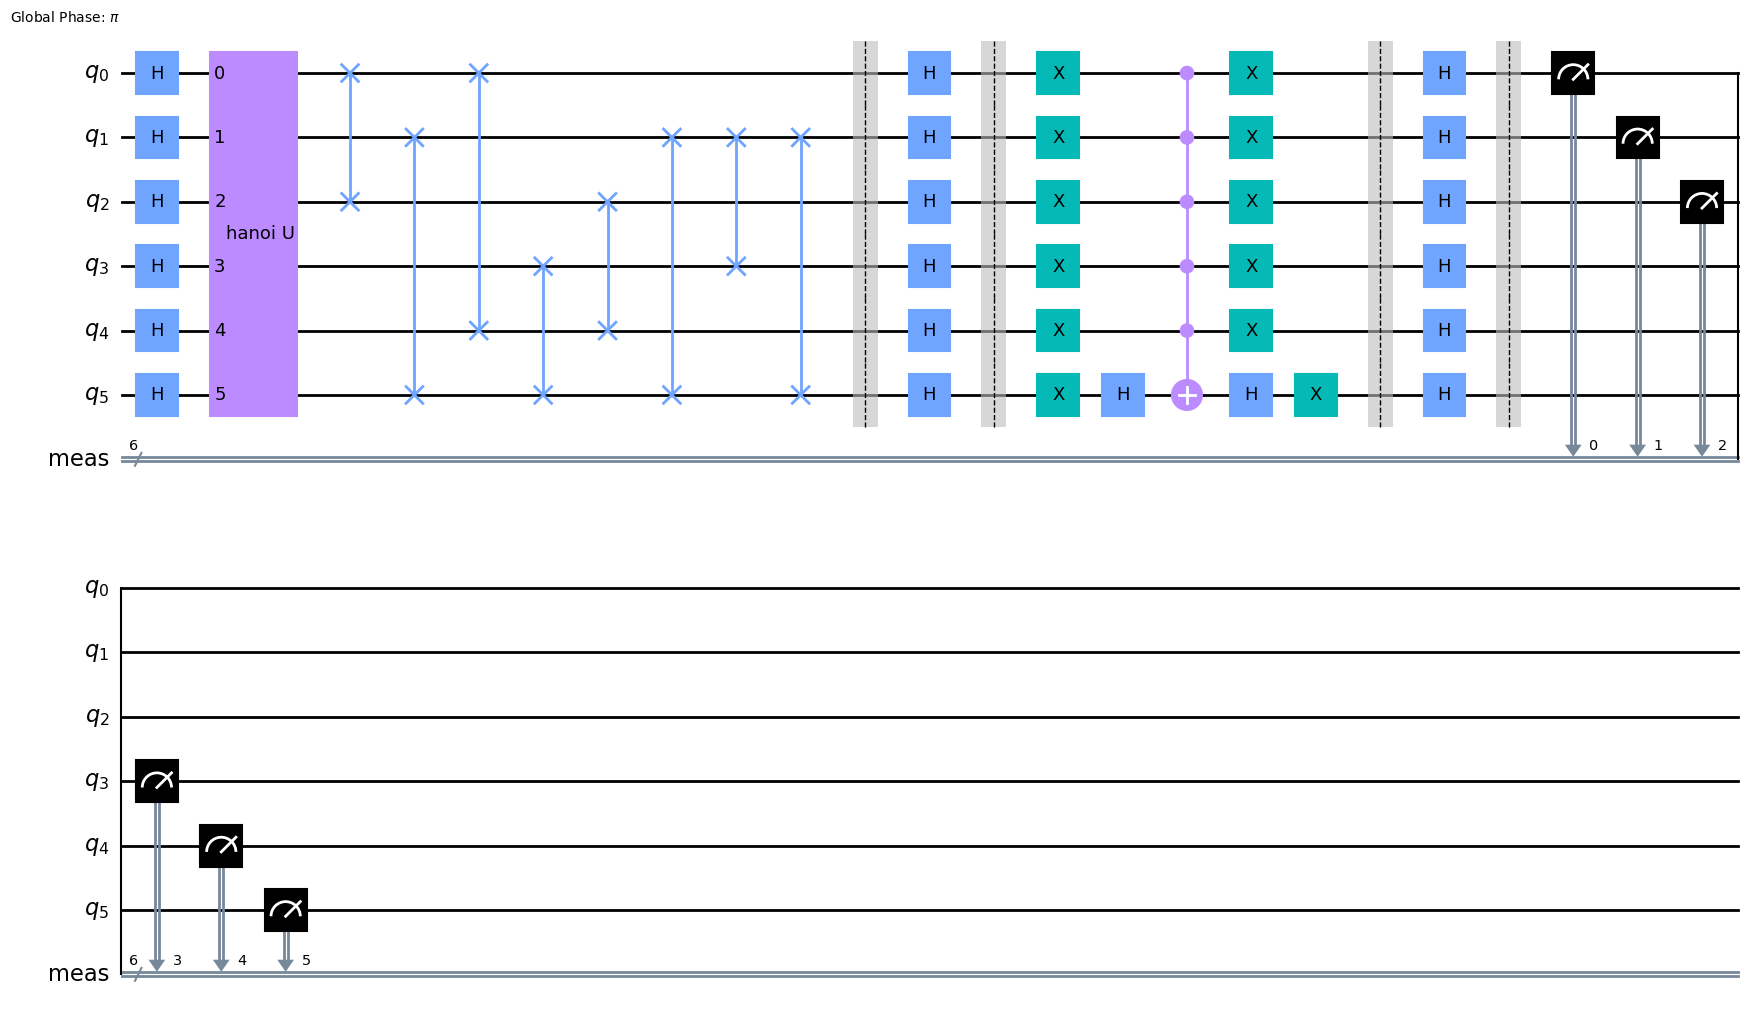

In [14]:
sampler = IBMSampler(backend=ibm_backend, options=options)

oracle = auto_hanoi(3)
grover = GroverOperator(oracle, insert_barriers=True).decompose()
n_qubits = oracle.num_qubits

grover.name = "Grover"

qc = QuantumCircuit(n_qubits)
qc.h(range(n_qubits))
qc.compose(grover, list(range(n_qubits)), inplace=True)
qc.measure_all()
display(qc.draw('mpl', style="clifford", filename=get_image_path("hanoi_3_discs_ibm_q_test.png")))
job = sampler.run(qc.decompose())

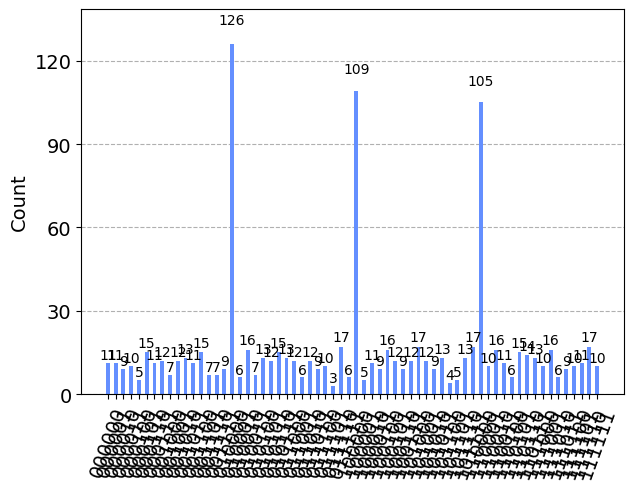

In [14]:
sim = AerSimulator()
result = sim.run(qc.decompose(), shots=1000).result().get_counts()
plot_histogram(result)

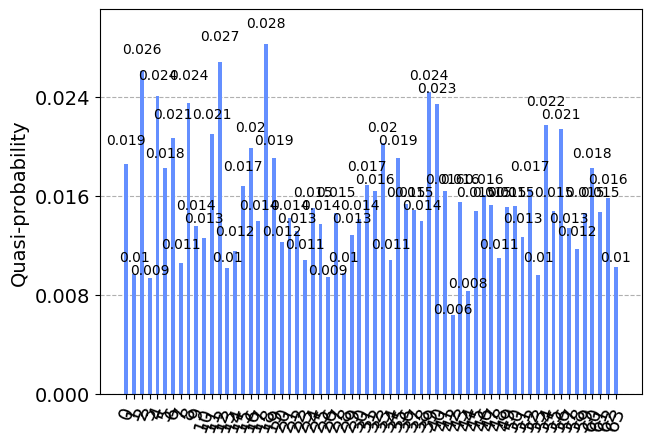

In [15]:
job_id = ''
job = service.job(job_id)
plot_distribution(job.result().quasi_dists)

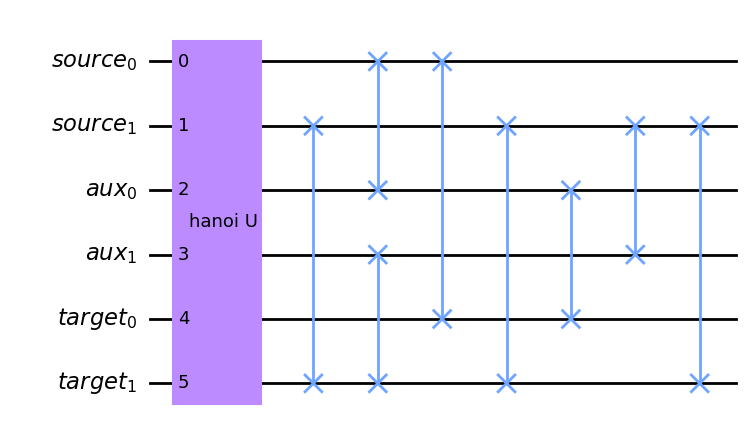

Reached the expected values: True
Top measurments: 100000


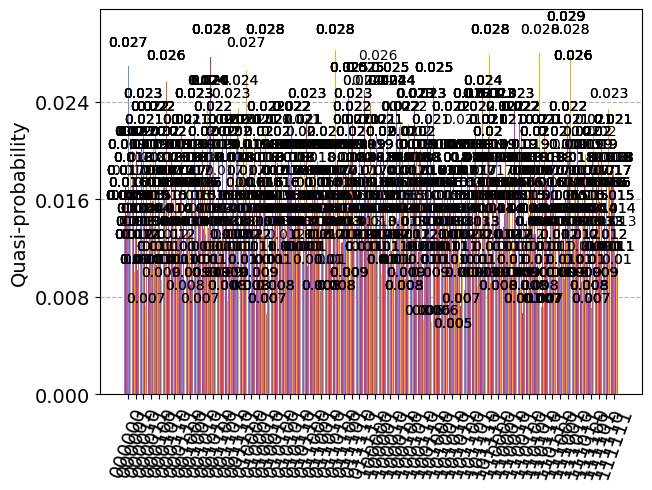

<Figure size 640x480 with 0 Axes>

In [20]:
sampler = IBMSampler(backend=ibm_backend, options=options)

test_result(auto_hanoi(3), ['010000', '100000', '110000'], filename=get_image_path("result_hanoi_3_discs_ibm_q.png"), sampler=sampler)